# Neural Network Examples - Feature Learning

This notebook aims to **visually demonstrate the power of neural networks as heirarchical feature learners**. Beyond this conceptual goal, it also aims to be a lightweight introduction to building/training neural networks in **Keras**, a user-friendly python wrapper for **tensorflow**.

## Installing Keras
TRY THIS FIRST (in command line):

conda install -c conda-forge keras

If that doesn't work - 

conda install tensorflow  
move into a folder for installing tools  
git clone https://github.com/fchollet/keras.git  
cd keras  
python setup.py install  

In [1]:
#Installing network structure viz

#!pip install pydot-ng
#!brew install graphviz
#!pip install pydot

## Digit Images Example (MNist)

We'll start by simply loading in the MNist digits data (restricted to digits 0-4), doing some PCA visualization in 2 dimensions, and seeing how well a simple linear model (softmax regression) can perform on this 2-dim representation.

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mnist = fetch_mldata("MNIST Original")
X_digits, Y_digits = mnist.data, mnist.target
X_digits, Y_digits = X_digits[Y_digits < 5], Y_digits[Y_digits < 5]

X_digits.shape

X_train, X_test, y_train, y_test = (train_test_split(X_digits, Y_digits, 
                                                     test_size = .2, random_state = 42))

As usual, we want to standard scale before running PCA.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Now we'll do dimensionality reduction to 2 principal components and visualize them. We can clearly see patterns that will let us separate the various digit classes, but also a lot of messiness. **We shouldn't expect a linear model to have outstanding performance** on this representation, since the classes are clearly not linearly separable.  

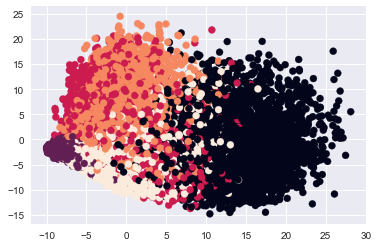

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

X_train_2PC = pca.fit_transform(X_train) 
X_test_2PC = pca.transform(X_test) 

plt.scatter(X_train_2PC[:,0], X_train_2PC[:,1], c = y_train)

Running the softmax regression confirms what we expected above - mediocre performance.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train)
lr.score(X_test_2PC, y_test)

0.6447460472925703

### Building a Neural Network Model

We've already taken the step of standard scaling our data, so we're nearly ready to build a NN. 

We do need to adjust the format of the training labels - right now we have a 1 dimensional array of digit labels like [0, 0, 1, 3, ...], but **multi-class NN output format requires a 2-dim array with binary columns corresponding to each class** (one hot encoding). Luckily, keras provides some utilities that let us easily reformat. 

In [6]:
from keras.utils import np_utils
y_train_cat = np_utils.to_categorical(y_train)

y_train_cat

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

Now we get to the fun part! We'll construct our first NN with Keras. 

Here's a quick breakdown of what all of these component parts are:

 * **Sequential** : default initialization of a multi-layer network
 * **Dense** : basic hidden layer type - fully connected, meaning that for each node we learn  a weight for each of the previous layer features, just like logistic regression. The first argument is the number of nodes (output feature dimensions) 
 
 
 * **Activation** : The nonlinearity we pass through at each layer. Typical choices are 'sigmoid', 'tanh', and 'relu', 'relu' often works best. The activation at the end (softmax in this case) corresponds to the output format we want, which in this case is multi-class. We would use sigmoid for binary classification, and no activation for a regression problem.
 * **Loss** and **Optimizer** : Which loss function to optimize for, and which style of gradient descent to use. 'adam' : adaptive momentum, often works really well for optimizing.
 
 
 * **Epochs** : Number of passes through the training data. Too few can underfit, too many can  overfit. Can be optimized with validation/CV including with early stopping methods.
 * **Batch Size** : Number of samples per gradient update. CF stochastic gradient descent - we train NNs through mini-batch gradient descent, and this controlls the mini-batch size. Larger batch sizes will lead to faster epochs but run the risk of causing arrival at local minima. 

In [7]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout

'''
 In this network structure, note that we follow a very common heuristic of "funneling"
 to lower dimensional representations over time with multiple layers. Tuning the exact
 choice of number of nodes and layers is quite challenging and there aren't generically
 correct choices, but this heuristic often works pretty well.
'''

NN = Sequential()

NN.add(Dense(100, input_dim = 784)) # need feature input dim (28x28) for first hidden layer
NN.add(Activation('relu'))

NN.add(Dense(20))
NN.add(Activation('relu'))

NN.add(Dense(2)) # note we would typically use higher dim than this for last hidden layer
NN.add(Activation('relu', name = '2D_layer')) # naming this layer so we can extract it later

NN.add(Dense(5))
NN.add(Activation('softmax'))

NN.compile(loss='categorical_crossentropy', optimizer='adam')
NN.fit(X_train, y_train_cat, epochs=20, batch_size=512, verbose=1) # track progress as we fit


Epoch 1/20
28588/28588 [==============================] - 0s - loss: 1.0022     
Epoch 2/20
28588/28588 [==============================] - 0s - loss: 0.6403     
Epoch 3/20
28588/28588 [==============================] - 0s - loss: 0.5117     
Epoch 4/20
28588/28588 [==============================] - 0s - loss: 0.3321     
Epoch 5/20
28588/28588 [==============================] - 0s - loss: 0.2838     
Epoch 6/20
28588/28588 [==============================] - 0s - loss: 0.2485     
Epoch 7/20
28588/28588 [==============================] - 0s - loss: 0.2189     
Epoch 8/20
28588/28588 [==============================] - 0s - loss: 0.1954     
Epoch 9/20
28588/28588 [==============================] - 0s - loss: 0.1761     
Epoch 10/20
28588/28588 [==============================] - 0s - loss: 0.1608     
Epoch 11/20
28588/28588 [==============================] - 0s - loss: 0.1457     
Epoch 12/20
28588/28588 [==============================] - 0s - loss: 0.1322     
Epoch 13/20
28588/28588 [

We've built and trained our model already, but even before training it we can get a summary of the network structure and visualize it to understand exactly how the model is set up.   

In [8]:
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
2D_layer (Activation)        (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
__________

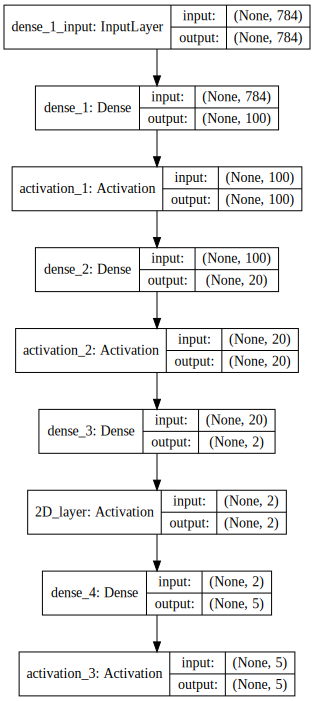

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(NN, show_shapes=True).create(prog='dot', format='svg'))

Of course we can also run predictions and score our model on the test data. It does really well!

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, NN.predict_classes(X_test))

5856/7147 [=======================>......] - ETA: 0s

0.9729956625157409

Next, to build some visual intuition for how neural networks perform **representation learning by creating new features (often in reduced dimensions)**, we're going to do something neat: extract the two node outputs from the last hidden layer and visualize them. 

In [11]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_test)

Now we'll plot the 2 feature representation learned by the neural network, and compare with the 2 principle components of the original data as before. Look at how the **neural network has created a beautiful, linearly separable representation** of the original data. 

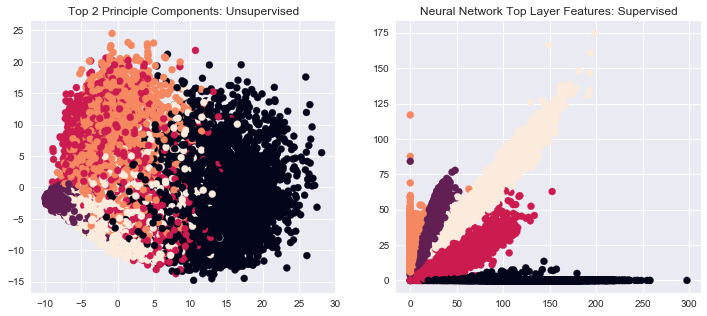

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X_train_2PC[:,0], X_train_2PC[:,1], c = y_train)
axes[0].set_title('Top 2 Principle Components: Unsupervised')

axes[1].scatter(X_train_NN_features_2d[:,0], X_train_NN_features_2d[:,1], c = y_train)
axes[1].set_title('Neural Network Top Layer Features: Supervised')

And as expected, a softmax regression shows very strong performance on the data representation that the network has learned. 

In [13]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_NN_features_2d, y_train)
lr.score(X_test_NN_features_2d, y_test)

0.9752343640688401

Hopefully this is a visually powerful representation of the **potential predictive power to be gained from using supervised feature learning / dimension reduction techniques**. Our neural network was designed to construct a 2-dimensional, linearly separable representation of the dataset and was able to accomplish this with flying colors.

Why does this happen? Here's some intuition. The network structure is set up to terminate in a simple softmax regression mapping to the final predictions (see output layer above). So the features that are fed to that mapping must be linearly separable for the network to predict well. In this sense, the **network is designed to create a final hidden layer of linearly separable features**. The beauty of the feed-forward / back-propogation structure is that it makes it possible to algorithmically generate this representation.

This is why I like to think of neural nets as **analagous to a supervised version of PCA**. They learn features in a heirarchical fashion that ultimately represent the input data in a much simpler and more useful way for prediction. 

PCA is unsupervised so can only represent the data in a simpler way based on explained variance, but neural nets are supervised so can represent the data in a simpler way based on **target explainability**.

## Digit Exercises

In [14]:
# EXERCISE: 
#   Reducing to a layer with 2 feature dimensions before the terminal softmax 
#   oversimplifies the model. Try adjusting the number of nodes in this layer to improve
#   the model's prediction performance.

# EXERCISE: 
#   Experiment with the network structure to try to improve performance. 
#   
#   Try adding or taking away nodes/layers. Look at the summary and visual diagram to
#   understand how the network and # of parameters are changing.

#   Try adjusting the number of epochs and the batch size. 
#   What impact do they have on performance?
#
#   Are you overfitting or underfitting? Is more or less complexity better? 
#   You can use # of parameters as a simple proxy for model complexity

# EXERCISE:
#   As you experiment with network structure, try to also incorporate dropout regularization.
#   See the bottom of the text example below for the syntax.

## Text Classification Example

Here we're going to look at a balanced binary text classification problem (sentiment detection), and train a **very simple neural network** - it will learn a 2-d representation of data just for the sake of visualization. Note that as in the digits example, this is making the model much simpler than it needs to be / below the level of complexity we would typically use in practice when building a predictive NN model.

In [15]:
import pandas as pd

df = pd.read_csv("Data/amazon_cells_labelled.txt", sep='\t', names=['text', 'sentiment'])
# Take a look
df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, 
                                                    test_size=0.2, random_state = 42)

tfidf_vect = TfidfVectorizer(decode_error = 'ignore')
X_train = tfidf_vect.fit_transform(X_train).todense()
X_test = tfidf_vect.transform(X_test).todense()

X_train.shape

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(800, 1630)

Here's our simple network to get a supervised, **2-dimensional embedding of the the tf-idf features**. 

In [17]:
NN = Sequential()

NN.add(Dense(2, input_dim = X_train.shape[1], name = '2D_layer'))
NN.add(Activation('relu'))

NN.add(Dense(1))
NN.add(Activation('sigmoid'))

NN.compile(loss='binary_crossentropy', optimizer='adam')
NN.fit(X_train, y_train, epochs=65, batch_size=128, verbose=1)

Epoch 1/65
800/800 [==============================] - 0s - loss: 0.6930     
Epoch 2/65
800/800 [==============================] - 0s - loss: 0.6907     
Epoch 3/65
800/800 [==============================] - 0s - loss: 0.6884     
Epoch 4/65
800/800 [==============================] - 0s - loss: 0.6859     
Epoch 5/65
800/800 [==============================] - 0s - loss: 0.6832     
Epoch 6/65
800/800 [==============================] - 0s - loss: 0.6801     
Epoch 7/65
800/800 [==============================] - 0s - loss: 0.6768     
Epoch 8/65
800/800 [==============================] - 0s - loss: 0.6732     
Epoch 9/65
800/800 [==============================] - 0s - loss: 0.6694     
Epoch 10/65
800/800 [==============================] - 0s - loss: 0.6656     
Epoch 11/65
800/800 [==============================] - 0s - loss: 0.6616     
Epoch 12/65
800/800 [==============================] - 0s - loss: 0.6576     
Epoch 13/65
800/800 [==============================] - 0s - loss: 0.6535 

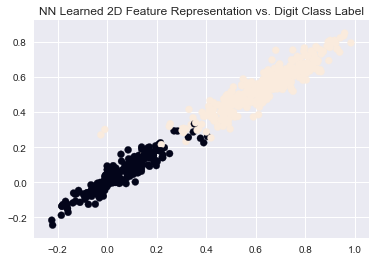

In [18]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_test)

plt.scatter(X_train_NN_features_2d[:,0], X_train_NN_features_2d[:,1], c = y_train)
plt.title('NN Learned 2D Feature Representation vs. Digit Class Label')

Neural networks can be a very powerful tool for working with text data, **provided there is enough data**. In this case, we're only training on 800 samples so we should not expect amazing generalization results from the network.

As we can see from plotting the **learned features for the test data set**, the representation that works extremely well for the training data does not generalize as well to unseen data.

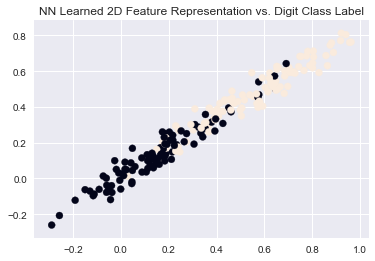

In [19]:
plt.scatter(X_test_NN_features_2d[:,0], X_test_NN_features_2d[:,1], c = y_test)
plt.title('NN Learned 2D Feature Representation vs. Digit Class Label')

In [20]:
accuracy_score(y_test, NN.predict_classes(X_test))

 32/200 [===>..........................] - ETA: 0s

0.795

We can power up the complexity of this NN by adding more layers and choosing a higher number of dimensions (hidden nodes) for the top layer, but it's hard to really do much better than our simple network. This example demonstrates that there's a risk of learning a representation that's overfit to the training data. **This overfitting becomes increasingly likely if we make the network excessively complex (too many nodes + layers)**. 

In this case, **we're likely better off just using a simple model like logistic regression or naive bayes on tf-idf features due to the small data size**.

In [21]:
lr = LogisticRegression(C = 100)
lr.fit(X_train, y_train)
print('Simple logistic score: {}'.format(lr.score(X_test, y_test)))

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
print('Naive Bayes score: {}'.format(nb.score(X_test, y_test)))

Simple logistic score: 0.855
Naive Bayes score: 0.855


And here is the fancy 3 layer network, which doesn't seem to be a real improvement from a simple baseline at all. 

In [22]:
from sklearn.metrics import accuracy_score

NN = Sequential()

NN.add(Dense(200, input_dim = X_train.shape[1]))
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(100))
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(50)) # 50 dimensional top-layer representation
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(1))
NN.add(Activation('sigmoid'))

NN.compile(loss='binary_crossentropy', optimizer='adam')
NN.fit(X_train, y_train, epochs=30, batch_size=512, verbose=1)

Epoch 1/30
800/800 [==============================] - 0s - loss: 0.6931     
Epoch 2/30
800/800 [==============================] - 0s - loss: 0.6903     
Epoch 3/30
800/800 [==============================] - 0s - loss: 0.6881     
Epoch 4/30
800/800 [==============================] - 0s - loss: 0.6838     
Epoch 5/30
800/800 [==============================] - 0s - loss: 0.6785     
Epoch 6/30
800/800 [==============================] - 0s - loss: 0.6712     
Epoch 7/30
800/800 [==============================] - 0s - loss: 0.6606     
Epoch 8/30
800/800 [==============================] - 0s - loss: 0.6454     
Epoch 9/30
800/800 [==============================] - 0s - loss: 0.6278     
Epoch 10/30
800/800 [==============================] - 0s - loss: 0.6062     
Epoch 11/30
800/800 [==============================] - 0s - loss: 0.5735     
Epoch 12/30
800/800 [==============================] - 0s - loss: 0.5375     
Epoch 13/30
800/800 [==============================] - 0s - loss: 0.4950 

In [23]:
accuracy_score(y_test, NN.predict_classes(X_test))

 32/200 [===>..........................] - ETA: 0s

0.86